In [14]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/UTEC/MACHINE LEARNING/tos_data'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import librosa
from IPython.display import Audio
import numpy as np
import pandas as pd

y, sr = librosa.load(path + "/Positive/23_Positive_female_33.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feacture Vector of the dog sound :" , feacture_vector)
Audio(data=y, rate=sr)

Feacture Vector of the dog sound : [-330.97916      61.76639     -31.694353     10.347196    -14.858851
   -3.104004    -15.246037    -11.8123045    -7.8924127    -5.9564967
   -9.212514     -9.10585      -1.3612156    -8.323147     -6.482363
   -8.070065     -0.47379833   -3.1981275    -3.391832      2.4135985 ]


In [ ]:
y, sr = librosa.load(path + "/Negative/0_Negative_male_26.wav" )
mfccs = librosa.feature.mfcc(y=y, sr=sr)
feacture_vector = np.array(mfccs.mean(axis = 1))
print("Feacture Vector of the dog sound :" , feacture_vector)
Audio(data=y, rate=sr)

Feacture Vector of the dog sound : [-340.55215      66.880646     -2.9464047    19.465425    -26.362059
   28.203428    -17.8379        2.6700819   -25.728811      1.1750404
    4.193242    -12.760353      0.4205562    -7.5001287     6.3850946
   -8.474143     -1.7675207    -9.965159     -0.90157217   -1.9528133 ]


Obtengo descriptivos sencillos de la data

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def audio_summary(path):
    stats = {
        "total": 0,
        "positive": 0,
        "negative": 0,
        "female": 0,
        "male": 0,
        "durations": []
    }

    # Helper para procesar archivos
    def process_files(subfolder, label):
        files = os.listdir(os.path.join(path, subfolder))
        stats[label] += len(files)
        stats["total"] += len(files)

        for f in files:
            full_path = os.path.join(path, subfolder, f)
            try:
                y, sr = librosa.load(full_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                stats["durations"].append(duration)

                if "female" in f.lower():
                    stats["female"] += 1
                else:
                    stats["male"] += 1
            except Exception as e:
                print(f"Error al procesar {f}: {e}")

    # Procesar ambas carpetas
    process_files("Positive", "positive")
    process_files("Negative", "negative")

    # Reporte
    print("📊 Resumen del Dataset de Audio")
    print(f"Total de archivos: {stats['total']}")
    print(f"  ➤ Positivos (COVID+): {stats['positive']}")
    print(f"  ➤ Negativos (COVID-): {stats['negative']}")
    print(f"  ➤ Femeninos: {stats['female']}")
    print(f"  ➤ Masculinos: {stats['male']}")
    print(f"Duración promedio: {np.mean(stats['durations']):.2f} segundos")
    print(f"Desviation Standar: {np.std(stats['durations']):.2f} segundos")
    print(f"Duración mínima: {np.min(stats['durations']):.2f} s | máxima: {np.max(stats['durations']):.2f} s")
    print(f"Duración P1: {np.percentile(stats['durations'], 1):.2f} s | P99: {np.percentile(stats['durations'], 99):.2f} s")

    # Histograma de duración
    plt.hist(stats["durations"], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel("Duración (segundos)")
    plt.ylabel("Número de audios")
    plt.title("Distribución de duración de los audios")
    plt.grid(True)
    plt.show()

    return stats


📊 Resumen del Dataset de Audio
Total de archivos: 1357
  ➤ Positivos (COVID+): 150
  ➤ Negativos (COVID-): 1207
  ➤ Femeninos: 313
  ➤ Masculinos: 1044
Duración promedio: 6.13 segundos
Desviation Standar: 2.64 segundos
Duración mínima: 0.26 s | máxima: 29.95 s
Duración P1: 1.60 s | P99: 14.69 s


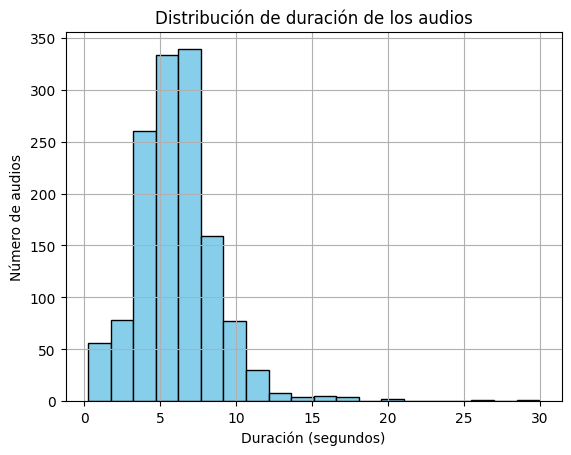

In [ ]:
_ = audio_summary(path)

Extrayendo la Data y transformandolo

In [ ]:
import numpy as np
import os

import numpy as np
from scipy.stats import skew, kurtosis
def safe_skew(mfcc_coef):
  return skew(mfcc_coef) if np.std(mfcc_coef) > 1e-6 else 0

def safe_kurtosis(mfcc_coef):
  return kurtosis(mfcc_coef) if np.std(mfcc_coef) > 1e-6 else 0

def extract_stats(mfcc):
  stats = []
  for coef in mfcc:
      stats.extend([
          np.mean(coef),
          np.std(coef),
          np.max(coef),
          np.min(coef),
          np.median(coef),
          np.max(coef) - np.min(coef),
          safe_skew(coef),
          safe_kurtosis(coef),
          np.percentile(coef, 25),
          np.percentile(coef, 75),
          np.percentile(coef, 75)-np.percentile(coef, 25)
      ])
  return np.array(stats)

def encode(path):
  data1 = []
  directory_1 = os.listdir(path + "/Negative")
  print(directory_1)
  for f  in directory_1:
    y, sr = librosa.load(path + "/Negative/" + f)
    mfccs = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40,n_fft=1024,hop_length=256,win_length=512,fmin=20,fmax=8000,n_mels=64)
    delta1_mfcc = librosa.feature.delta(mfccs, order=1)
    delta2_mfcc = librosa.feature.delta(mfccs, order=2)
    mfccs_stat = extract_stats(mfccs)
    delta1_mfcc = extract_stats(delta1_mfcc)
    delta2_mfcc = extract_stats(delta2_mfcc)
    fv = np.concatenate((mfccs_stat,delta1_mfcc, delta2_mfcc))
    if("female" in f):
      fv = np.append(fv,0)
    else:
      fv = np.append(fv,1)
    data1.append(fv)
  data = np.array(data1)
  data  = np.insert(data, 0, 0, axis=1)

  data2 = []
  directory_2 =  os.listdir(path + "/Positive")
  print(directory_2)
  for f  in directory_2:
    y, sr = librosa.load(path + "/Positive/" + f)
    mfccs = librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40,n_fft=1024,hop_length=256,win_length=512,fmin=20,fmax=8000,n_mels=64)
    delta1_mfcc = librosa.feature.delta(mfccs, order=1)
    delta2_mfcc = librosa.feature.delta(mfccs, order=2)
    mfccs_stat = extract_stats(mfccs)
    delta1_mfcc_stat = extract_stats(delta1_mfcc)
    delta2_mfcc_stat = extract_stats(delta2_mfcc)
    fv = np.concatenate((mfccs_stat,delta1_mfcc_stat, delta2_mfcc_stat))
    if("female" in f):
      fv = np.append(fv,0)
    else:
      fv = np.append(fv,1)
    data2.append(fv)
  temp = np.array(data2)
  temp = np.insert(temp, 0, 1, axis=1)


  data = np.concatenate((data, temp), axis=0)
  np.random.seed(42)
  np.random.shuffle(data)
  y = data[:,0]
  x = data[:, 1:]
  return x, y


In [ ]:
X,Y = encode(path)

['1230_Negative_male_35.wav', '1248_Negative_male_17.wav', '1218_Negative_male_23.wav', '1239_Negative_female_24.wav', '1252_Negative_female_28.wav', '1254_Negative_male_31.wav', '1257_Negative_male_28.wav', '1256_Negative_male_35.wav', '1242_Negative_male_33.wav', '1215_Negative_male_43.wav', '123_Negative_male_33.wav', '1249_Negative_male_21.wav', '1217_Negative_male_21.wav', '1228_Negative_male_35.wav', '121_Negative_female_38.wav', '1226_Negative_male_21.wav', '1240_Negative_male_64.wav', '1227_Negative_male_44.wav', '1245_Negative_male_21.wav', '1221_Negative_male_18.wav', '1232_Negative_male_42.wav', '1255_Negative_female_39.wav', '1250_Negative_male_32.wav', '1223_Negative_male_25.wav', '1214_Negative_male_20.wav', '1244_Negative_female_32.wav', '1225_Negative_male_35.wav', '124_Negative_male_55.wav', '1236_Negative_male_27.wav', '122_Negative_male_20.wav', '1247_Negative_male_29.wav', '1222_Negative_male_29.wav', '1231_Negative_male_24.wav', '1233_Negative_female_20.wav', '1216

In [ ]:
X.shape

(1357, 1321)

In [ ]:
sum(Y)

np.float64(150.0)

Normalizacion de los features

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

PCA PARA REDUCIR LA DIMENSIONALIDAD MANTENIENDO INFORMACION

In [47]:
from sklearn.decomposition import PCA

print(f"Shape antes de PCA: {X_scaled.shape}")

#Asegurar el 80% de la variancia
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X_scaled)
print(f"Shape después de PCA: {X_pca.shape}")

Shape antes de PCA: (1357, 1321)
Shape después de PCA: (1357, 102)


DIVISION DEL SET EN TRAIN Y TEST (80%-20%)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

In [49]:
np.mean(y_train),np.mean(y_test)

(np.float64(0.11152073732718894), np.float64(0.10661764705882353))

In [50]:
np.sum(y_train),np.sum(y_test)

(np.float64(121.0), np.float64(29.0))

La data se ecuentra desbalanceada por lo cual se realizara un oversampling para el balanceo de solo el train dataset

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=132641)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [52]:
np.mean(y_train),np.mean(y_train_bal),np.sum(y_train),np.sum(y_train_bal),y_train.shape[0],y_train_bal.shape[0]

(np.float64(0.11152073732718894),
 np.float64(0.5),
 np.float64(121.0),
 np.float64(964.0),
 1085,
 1928)

**ENTRENAMIENTO BASE DE LOS MODELOS: REGRESION LOGISTICA, SVM , DECISION TREE , KNN, XGBOOST CON PARAMETROS POR DEFAULT**

In [53]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, precision_recall_curve

def getBestThreshold(pred_scores,y_test):
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_scores)

  f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

  best_threshold = thresholds[np.argmax(f1_scores)]

  y_pred_opt = (pred_scores >= best_threshold).astype(int)

  return best_threshold,y_pred_opt

Utilizaremos KFold CrossValidation, siendo K=5, para la evaluacion de las metricas base

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
# Configurar KFold con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

aucs_svm,aucs_logit,aucs_knn,aucs_tree,aucs_xgb = [],[],[],[],[]
f1s_svm,f1s_logit,f1s_knn,f1s_tree,f1s_xgb = [],[],[],[],[]

for fold, (train_index, val_index) in enumerate(kf.split(X_train_bal), 1):
  X_train_fold, X_val_fold = X_train_bal[train_index], X_train_bal[val_index]
  y_train_fold, y_val_fold = y_train_bal[train_index], y_train_bal[val_index]

  # Entrenar los modelo
  svm_model = SVC(random_state=42)
  svm_model.fit(X_train_fold, y_train_fold)

  logit_model = LogisticRegression(solver='liblinear',random_state=42)
  logit_model.fit(X_train_fold, y_train_fold)

  knn = KNeighborsClassifier(n_neighbors=3)
  knn.fit(X_train_fold, y_train_fold)

  tree = DecisionTreeClassifier(random_state=42)
  tree.fit(X_train_fold, y_train_fold)

  xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=42)
  xgb_model.fit(X_train_fold, y_train_fold)

  # Prediccion de los modelos con probabilidad
  y_pred_svm_prob   = svm_model.decision_function(X_val_fold)
  y_pred_logit_prob = logit_model.predict_proba(X_val_fold)[:, 1]
  y_pred_knn_prob   = knn.predict_proba(X_val_fold)[:, 1]
  y_pred_tree_prob  = tree.predict_proba(X_val_fold)[:, 1]
  y_pred_xgb_prob   = xgb_model.predict_proba(X_val_fold)[:, 1]

  # Calcular AUC
  auc_svm   = roc_auc_score(y_val_fold, y_pred_svm_prob)
  auc_logit = roc_auc_score(y_val_fold, y_pred_logit_prob)
  auc_knn   = roc_auc_score(y_val_fold, y_pred_knn_prob)
  auc_tree  = roc_auc_score(y_val_fold, y_pred_tree_prob)
  auc_xgb   = roc_auc_score(y_val_fold, y_pred_xgb_prob)
  aucs_svm.append(auc_svm)
  aucs_logit.append(auc_logit)
  aucs_knn.append(auc_knn)
  aucs_tree.append(auc_tree)
  aucs_xgb.append(auc_xgb)

  #Calcular el F1 SCORE, OPTIMIZANDO EL THRESHOLD
  _,y_pred_svm_opt    = getBestThreshold(y_pred_svm_prob,y_val_fold)
  _,y_pred_logit_opt  = getBestThreshold(y_pred_logit_prob,y_val_fold)
  _,y_pred_knn_opt    = getBestThreshold(y_pred_knn_prob,y_val_fold)
  _,y_pred_tree_opt   = getBestThreshold(y_pred_tree_prob,y_val_fold)
  _,y_pred_xgb_opt    = getBestThreshold(y_pred_xgb_prob,y_val_fold)

  f1s_svm.append(f1_score(y_val_fold, y_pred_svm_opt,average='binary'))
  f1s_logit.append(f1_score(y_val_fold, y_pred_logit_opt,average='binary'))
  f1s_knn.append(f1_score(y_val_fold, y_pred_knn_opt,average='binary'))
  f1s_tree.append(f1_score(y_val_fold, y_pred_tree_opt,average='binary'))
  f1s_xgb.append(f1_score(y_val_fold, y_pred_xgb_opt,average='binary'))

  print(f"Fold {fold}")
  print(f"  SVM: AUC {aucs_svm[-1]} - F1SCORE: {f1s_svm[-1]:.4f}")
  print(f"  REG LOGIT: AUC {aucs_logit[-1]} - F1SCORE: {f1s_logit[-1]:.4f}")
  print(f"  KNN: AUC {aucs_knn[-1]} - F1SCORE: {f1s_knn[-1]:.4f}")
  print(f"  DECISION TREE: AUC {aucs_tree[-1]} - F1SCORE: {f1s_tree[-1]:.4f}")
  print(f"  XGBOOST: AUC {aucs_xgb[-1]} - F1SCORE: {f1s_xgb[-1]:.4f}")

Fold 1
  SVM: AUC 0.9879191387688261 - F1SCORE: 0.9561
  REG LOGIT: AUC 0.904749120781766 - F1SCORE: 0.8655
  KNN: AUC 0.8886010362694301 - F1SCORE: 0.8998
  DECISION TREE: AUC 0.8445595854922279 - F1SCORE: 0.8515
  XGBOOST: AUC 0.9983623721442186 - F1SCORE: 0.9819
Fold 2
  SVM: AUC 0.9854189044038668 - F1SCORE: 0.9521
  REG LOGIT: AUC 0.9248657357679914 - F1SCORE: 0.8615
  KNN: AUC 0.9033431793770139 - F1SCORE: 0.9082
  DECISION TREE: AUC 0.8481203007518797 - F1SCORE: 0.8543
  XGBOOST: AUC 0.9967776584317938 - F1SCORE: 0.9789
Fold 3
  SVM: AUC 0.9933306440769127 - F1SCORE: 0.9653
  REG LOGIT: AUC 0.9315853166599435 - F1SCORE: 0.8723
  KNN: AUC 0.9303482587064676 - F1SCORE: 0.9296
  DECISION TREE: AUC 0.8839720317332259 - F1SCORE: 0.8806
  XGBOOST: AUC 0.999381471023262 - F1SCORE: 0.9919
Fold 4
  SVM: AUC 0.9821254995139865 - F1SCORE: 0.9409
  REG LOGIT: AUC 0.8993411815530835 - F1SCORE: 0.8516
  KNN: AUC 0.8926584944378443 - F1SCORE: 0.8998
  DECISION TREE: AUC 0.8614726212333946 - F1

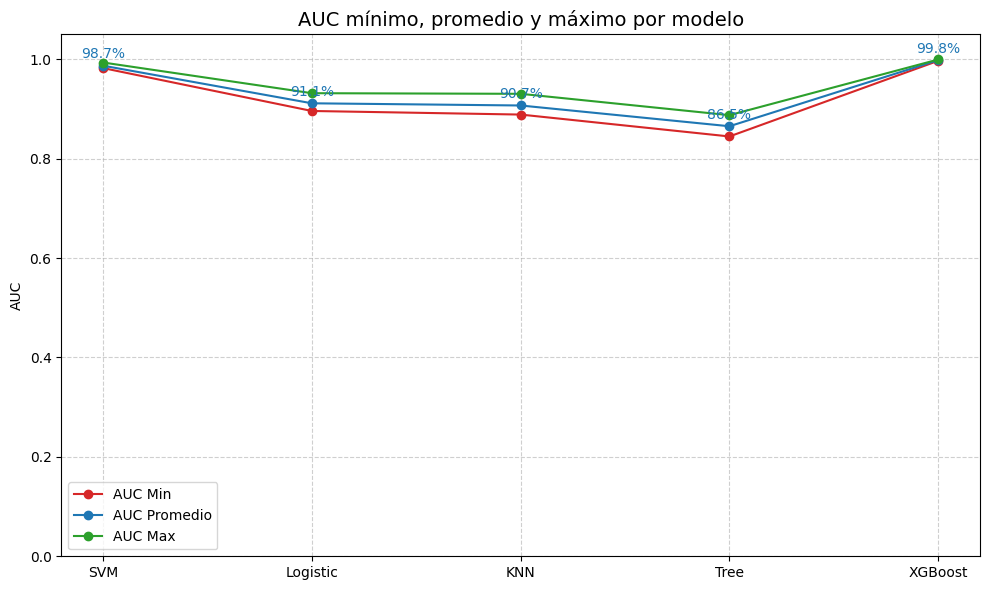

In [55]:
#Obteniendo el promedio, minimo y maximo AUC y F1 SCORE
import seaborn as sns
import matplotlib.pyplot as plt

auc_dict = {
    'SVM': aucs_svm,
    'Logistic': aucs_logit,
    'KNN': aucs_knn,
    'Tree': aucs_tree,
    'XGBoost': aucs_xgb
}

summary = []
for modelo, aucs in auc_dict.items():
    summary.append({
        'Modelo': modelo,
        'AUC Min': np.min(aucs),
        'AUC Promedio': np.mean(aucs),
        'AUC Max': np.max(aucs)
    })

df_summary = pd.DataFrame(summary)

# Transponer para graficar por métrica
df_plot = df_summary.set_index('Modelo').T  # filas: métricas, columnas: modelos

# Graficar
plt.figure(figsize=(10, 6))

# Colores personalizados por métrica
colors = {
    'AUC Min': '#d62728',       # rojo
    'AUC Promedio': '#1f77b4',  # azul
    'AUC Max': '#2ca02c'        # verde
}

# Graficar cada métrica
for metric in df_plot.index:
    plt.plot(df_plot.columns, df_plot.loc[metric], marker='o', label=metric, color=colors[metric])

    # Solo agregar etiquetas de porcentaje para el promedio
    if metric == 'AUC Promedio':
        for i, modelo in enumerate(df_plot.columns):
            val = df_plot.loc[metric, modelo]
            plt.text(i, val + 0.015, f"{val*100:.1f}%", ha='center', fontsize=10, color=colors[metric])

plt.title('AUC mínimo, promedio y máximo por modelo', fontsize=14)
plt.ylabel('AUC')
plt.ylim(0.0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

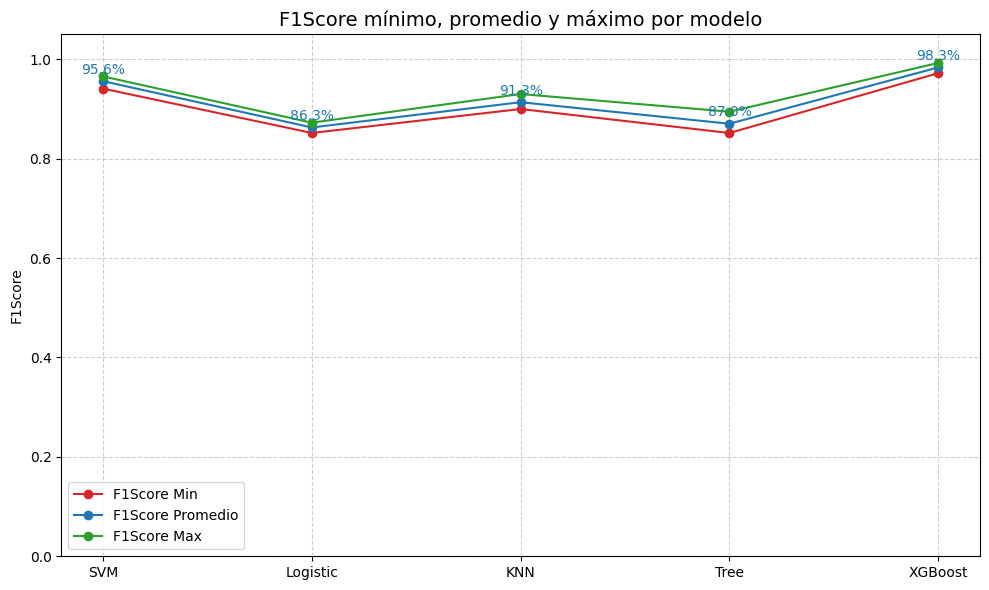

In [56]:
#Obteniendo el promedio, minimo y maximo F1 SCORE
import seaborn as sns
import matplotlib.pyplot as plt

auc_dict = {
    'SVM': f1s_svm,
    'Logistic': f1s_logit,
    'KNN': f1s_knn,
    'Tree': f1s_tree,
    'XGBoost': f1s_xgb
}

summary = []
for modelo, aucs in auc_dict.items():
    summary.append({
        'Modelo': modelo,
        'F1Score Min': np.min(aucs),
        'F1Score Promedio': np.mean(aucs),
        'F1Score Max': np.max(aucs)
    })

df_summary = pd.DataFrame(summary)

# Transponer para graficar por métrica
df_plot = df_summary.set_index('Modelo').T  # filas: métricas, columnas: modelos

# Graficar
plt.figure(figsize=(10, 6))

# Colores personalizados por métrica
colors = {
    'F1Score Min': '#d62728',       # rojo
    'F1Score Promedio': '#1f77b4',  # azul
    'F1Score Max': '#2ca02c'        # verde
}

# Graficar cada métrica
for metric in df_plot.index:
    plt.plot(df_plot.columns, df_plot.loc[metric], marker='o', label=metric, color=colors[metric])

    # Solo agregar etiquetas de porcentaje para el promedio
    if metric == 'F1Score Promedio':
        for i, modelo in enumerate(df_plot.columns):
            val = df_plot.loc[metric, modelo]
            plt.text(i, val + 0.015, f"{val*100:.1f}%", ha='center', fontsize=10, color=colors[metric])

plt.title('F1Score mínimo, promedio y máximo por modelo', fontsize=14)
plt.ylabel('F1Score')
plt.ylim(0.0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Entrenando los mismos modelos sobre el total del train (balanceado) y evaluandolo sobre el test (desbalanceado)

In [57]:
# Write here your o yours models.
svm_model = SVC(random_state=42)
svm_model.fit(X_train_bal, y_train_bal)

logit_model = LogisticRegression(solver='liblinear',random_state=42)
logit_model.fit(X_train_bal, y_train_bal)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_bal, y_train_bal)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_bal, y_train_bal)

xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss',random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [58]:
#CODIGO PARA EL F1_SCORE, ACCURRACY, PRECISION, RECALL
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

def obtener_metricas(y_test, y_pred, TIPO):
    return pd.DataFrame({
        'Modelo': [TIPO],
        'Accuracy': [accuracy_score(y_test, y_pred)],
        'Precision': [precision_score(y_test, y_pred,average='binary')],
        'Recall': [recall_score(y_test, y_pred,average='binary')],
        'F1-Score': [f1_score(y_test, y_pred,average='binary')]
    })

In [73]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def matriz_confusion(y_test, y_pred, Tipo=""):
    matrix = confusion_matrix(y_test, y_pred)
    # Normalizar por fila y convertir a porcentaje
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100,
                      index=["NO COVID", 'COVID'],
                      columns=["NO COVID", 'COVID'])

    plt.figure(figsize=(6, 4))
    sns.heatmap(f2, annot=True, fmt=".1f", cmap="Greens", cbar=False)
    plt.title("Confusion Matrix" + Tipo)
    plt.xlabel("Predicha")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()


In [60]:
y_pred_svm_prob = svm_model.decision_function(X_test)
y_pred_logit_prob =    logit_model.predict_proba(X_test)[:, 1]
y_pred_knn_prob =      knn.predict_proba(X_test)[:, 1]
y_pred_tree_prob =     tree.predict_proba(X_test)[:, 1]
y_pred_xgb_prob =     xgb_model.predict_proba(X_test)[:, 1]

In [61]:
_,y_pred_svm_opt = getBestThreshold(y_pred_svm_prob,y_test)
_,y_pred_logit_opt = getBestThreshold(y_pred_logit_prob,y_test)
_,y_pred_knn_opt = getBestThreshold(y_pred_knn_prob,y_test)
_,y_pred_tree_opt = getBestThreshold(y_pred_tree_prob,y_test)
_,y_pred_xgb_opt = getBestThreshold(y_pred_xgb_prob,y_test)

In [62]:
modelos_metricas = []
modelos_metricas.append(obtener_metricas(y_test, y_pred_svm_opt, 'SVM'))
modelos_metricas.append(obtener_metricas(y_test, y_pred_logit_opt, 'Logistic Regression'))
modelos_metricas.append(obtener_metricas(y_test, y_pred_knn_opt, 'KNN'))
modelos_metricas.append(obtener_metricas(y_test, y_pred_tree_opt, 'Decision Tree'))
modelos_metricas.append(obtener_metricas(y_test, y_pred_xgb_opt, 'XGB'))

resultados_df = pd.concat(modelos_metricas, ignore_index=True)

# Mostrar resultados
print(resultados_df)


                Modelo  Accuracy  Precision    Recall  F1-Score
0                  SVM  0.926471   0.695652  0.551724  0.615385
1  Logistic Regression  0.900735   0.525000  0.724138  0.608696
2                  KNN  0.794118   0.298507  0.689655  0.416667
3        Decision Tree  0.830882   0.311111  0.482759  0.378378
4                  XGB  0.937500   0.750000  0.620690  0.679245


In [69]:
aucs_test = [roc_auc_score(y_test,y_pred_svm_prob),roc_auc_score(y_test,y_pred_logit_prob),roc_auc_score(y_test,y_pred_knn_prob),roc_auc_score(y_test,y_pred_tree_prob),roc_auc_score(y_test,y_pred_xgb_prob)]
print(f"  SVM: AUC {roc_auc_score(y_test,y_pred_svm_prob):.3f}")
print(f"  Logistic Regression: AUC {roc_auc_score(y_test,y_pred_logit_prob):.3f}")
print(f"  KNN: AUC {roc_auc_score(y_test,y_pred_knn_prob):.3f}")
print(f"  DECISION TREE: AUC {roc_auc_score(y_test,y_pred_tree_prob):.3f}")
print(f"  XGB: AUC {roc_auc_score(y_test,y_pred_xgb_prob):.3f}")

  SVM: AUC 0.879
  Logistic Regression: AUC 0.845
  KNN: AUC 0.775
  DECISION TREE: AUC 0.678
  XGB: AUC 0.886


In [70]:
resultados_df['auc'] = aucs_test
resultados_df

,Modelo,Accuracy,Precision,Recall,F1-Score,auc
0,SVM,0.926471,0.695652,0.551724,0.615385,0.879097
1,Logistic Regression,0.900735,0.525000,0.724138,0.608696,0.845466
2,KNN,0.794118,0.298507,0.689655,0.416667,0.774514
3,Decision Tree,0.830882,0.311111,0.482759,0.378378,0.677593
4,XGB,0.937500,0.750000,0.620690,0.679245,0.886477


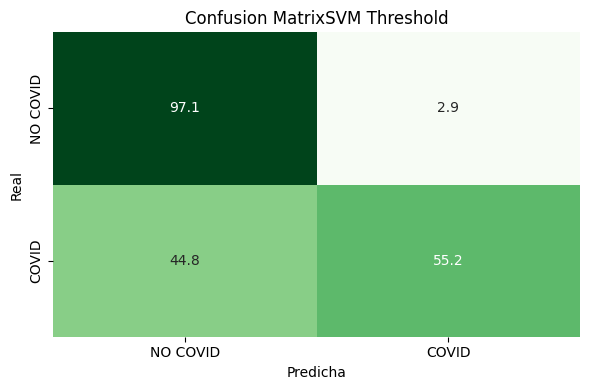

In [74]:
matriz_confusion(y_test, y_pred_svm_opt,"SVM Threshold")

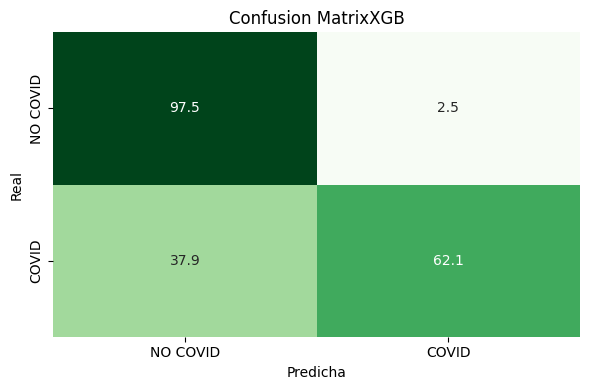

In [75]:
matriz_confusion(y_test, y_pred_xgb_opt,"XGB")

**OPTIMIZACION DE PARAMETROS DE LOS MODELOS CON MEJORES RESULTADOS: SVM - XGBOOST**

In [76]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.9 MB/s eta 0:00:00


In [77]:
import optuna
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from optuna.samplers import TPESampler

results = []

def objective(trial):
  kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"])
  C = trial.suggest_float("C", 0.01, 10.0, log=True)
  gamma = "scale"  # SVM lineal no usa gamma

  svm_model = SVC(kernel=kernel,C=C,gamma=gamma,degree=3,random_state=42)

  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  f1_cv = cross_val_score(svm_model, X_train_bal, y_train_bal, cv=cv, scoring=make_scorer(f1_score, average='binary')).mean()

  # GUARDANDO INFORMACION DE LOS MEJORES TRIALS

  if len(results) == 0 or f1_cv > trial.study.best_value:
    svm_model = SVC(kernel=kernel,C=C,gamma=gamma,degree=3,random_state=42)
    svm_model.fit(X_train_bal, y_train_bal)
    y_pred_test = svm_model.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test,average='binary')

    results.append({
      "trial_number": trial.number,
      "f1_cv": f1_cv,
      "f1_test": f1_test,
      "params": trial.params
    })

  return f1_cv

# 3. Crear estudio Optuna y optimizar
sampler = TPESampler(seed=132641)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# 4. Resultados
print("Mejores hiperparámetros:", study.best_params)
print(f"Mejor accuracy: {study.best_value:.4f}")

[I 2025-07-06 17:35:07,767] A new study created in memory with name: no-name-cef649df-0f98-4c66-a7aa-b2348795aef7
[I 2025-07-06 17:35:10,645] Trial 0 finished with value: 0.5507928112499891 and parameters: {'kernel': 'rbf', 'C': 0.028498253040202953}. Best is trial 0 with value: 0.5507928112499891.
[I 2025-07-06 17:41:45,057] Trial 1 finished with value: 0.8537459262986156 and parameters: {'kernel': 'linear', 'C': 4.216916054768918}. Best is trial 1 with value: 0.8537459262986156.
[I 2025-07-06 17:41:46,691] Trial 2 finished with value: 0.5997993004954368 and parameters: {'kernel': 'sigmoid', 'C': 3.6689971335046745}. Best is trial 1 with value: 0.8537459262986156.
[I 2025-07-06 17:44:38,632] Trial 3 finished with value: 0.8536853494938527 and parameters: {'kernel': 'linear', 'C': 2.184007476340625}. Best is trial 1 with value: 0.8537459262986156.
[I 2025-07-06 17:44:40,277] Trial 4 finished with value: 0.600442428677747 and parameters: {'kernel': 'sigmoid', 'C': 2.2198665747578765}. B

Mejores hiperparámetros: {'kernel': 'rbf', 'C': 5.283512344420064}
Mejor accuracy: 0.9832


In [78]:
import optuna
from optuna.visualization import plot_optimization_history

plot_optimization_history(study).show()

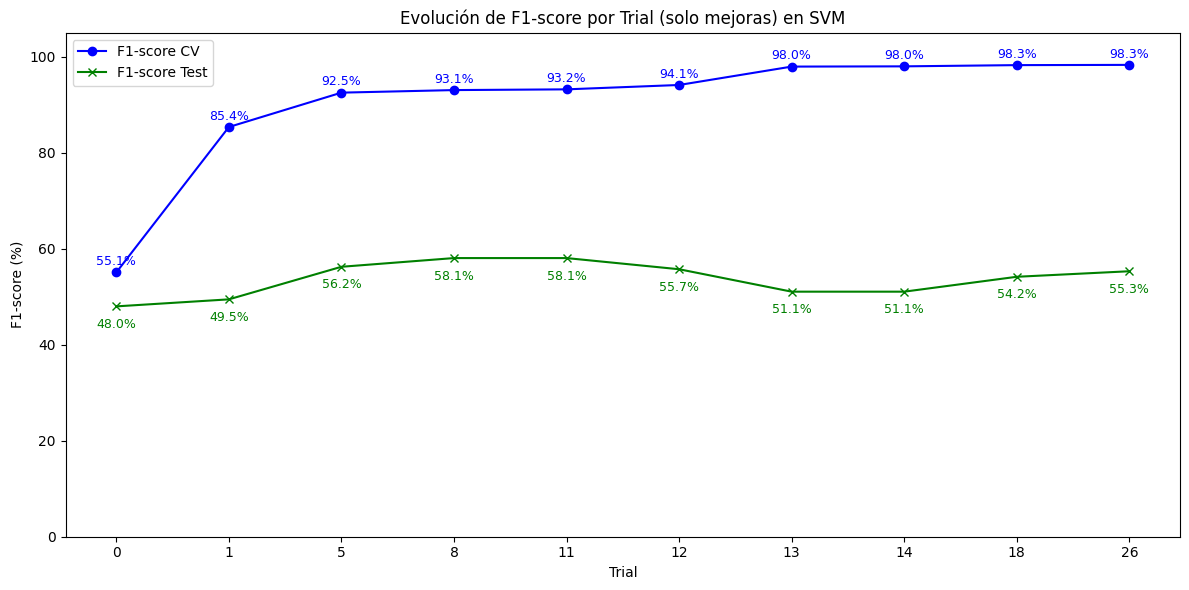

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

df_best_trials = pd.DataFrame(results).reset_index(drop=True)

plt.figure(figsize=(12, 6))

x_vals = df_best_trials.index  # índices equidistantes

# Gráficas
plt.plot(x_vals, df_best_trials["f1_cv"]* 100, marker="o", label="F1-score CV", color="blue")
plt.plot(x_vals, df_best_trials["f1_test"]* 100, marker="x", label="F1-score Test", color="green")

# Anotar valores en porcentaje con 1 decimal
for i, row in df_best_trials.iterrows():
    plt.text(i, row["f1_cv"] * 100 + 1.5, f"{row['f1_cv'] * 100:.1f}%", color="blue", ha="center", fontsize=9)
    plt.text(i, row["f1_test"] * 100 - 4.5, f"{row['f1_test'] * 100:.1f}%", color="green", ha="center", fontsize=9)

# Etiquetas del eje X
plt.xticks(ticks=x_vals, labels=df_best_trials["trial_number"])

# Estética
plt.title("Evolución de F1-score por Trial (solo mejoras) en SVM")
plt.xlabel("Trial")
plt.ylabel("F1-score (%)")
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()

# Eliminar grid
plt.grid(False)

plt.show()


In [84]:
svm_model = SVC(**study.best_params)
svm_model.fit(X_train_bal, y_train_bal)
y_pred_test = svm_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test,average='binary')
print("F1-score en Test:", f1_test)
y_pred_svm_prob = svm_model.decision_function(X_test)
_,y_pred_svm_opt = getBestThreshold(y_pred_svm_prob,y_test)
f1_test_opt = f1_score(y_test, y_pred_svm_opt,average='binary')
print("F1-score opt en Test:", f1_test_opt)


F1-score en Test: 0.5531914893617021
F1-score opt en Test: 0.5531914893617021


In [85]:
params_5 = df_best_trials[df_best_trials['trial_number']==11]['params'].values[0]
params_5

{'kernel': 'rbf', 'C': 0.5209774045270671}

In [86]:
svm_model = SVC(**params_5)
svm_model.fit(X_train_bal, y_train_bal)
y_pred_test = svm_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test,average='binary')
print("F1-score en Test:", f1_test)
y_pred_svm_prob = svm_model.decision_function(X_test)
_,y_pred_svm_opt = getBestThreshold(y_pred_svm_prob,y_test)
f1_test_opt = f1_score(y_test, y_pred_svm_opt,average='binary')
print("F1-score opt en Test:", f1_test_opt)


F1-score en Test: 0.5806451612903226
F1-score opt en Test: 0.6415094339622641


In [87]:

results = []

def objective(trial):
  params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "booster": "gbtree",
    "verbosity": 0,
    "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.3),
    "max_depth": trial.suggest_int("max_depth", 3, 8),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    "gamma": trial.suggest_float("gamma", 0, 1),
    "subsample": trial.suggest_float("subsample", 0.5, 1),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
    "lambda": trial.suggest_float("lambda", 0.1, 1.0, log=True),
    "alpha": trial.suggest_float("alpha", 0.1, 1.0, log=True),
  }

  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
  f1_scores = []

  for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_train_cv, X_val_cv = X_train_bal[train_idx], X_train_bal[val_idx]
    y_train_cv, y_val_cv = y_train_bal[train_idx], y_train_bal[val_idx]

    dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dval = xgb.DMatrix(X_val_cv, label=y_val_cv)

    model = xgb.train(
      params,
      dtrain,
      num_boost_round=1000,
      evals=[(dval, "validation")],
      early_stopping_rounds=50,
      verbose_eval=False
    )

    preds_prob = model.predict(dval)
    preds = (preds_prob >= 0.5).astype(int)
    f1 = f1_score(y_val_cv, preds)
    f1_scores.append(f1)


  # GUARDANDO INFORMACION DE LOS MEJORES TRIALS

  if len(results) == 0 or np.mean(f1_scores) > trial.study.best_value:
    xgb_model = xgb.XGBClassifier(**trial.params, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train_bal, y_train_bal)
    y_pred_test = xgb_model.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test,average='binary')

    results.append({
      "trial_number": trial.number,
      "f1_cv": np.mean(f1_scores),
      "f1_test": f1_test,
      "params": trial.params
    })

  return np.mean(f1_scores)

# Estudy
sampler = TPESampler(seed=132641)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)


# Resultados
print("Mejores parámetros:")
print(study.best_params)
print(f"Mejor F1 promedio en CV: {study.best_value:.4f}")


[I 2025-07-06 18:32:08,913] A new study created in memory with name: no-name-178db661-6caf-4731-8132-2fce08a7578b
[I 2025-07-06 18:32:18,364] Trial 0 finished with value: 0.968531543768821 and parameters: {'learning_rate': 0.27970607494809596, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.1516060794384657, 'subsample': 0.7123444083433674, 'colsample_bytree': 0.5606941588425916, 'lambda': 0.24179382763891566, 'alpha': 0.7498913060123343}. Best is trial 0 with value: 0.968531543768821.
[I 2025-07-06 18:32:26,761] Trial 1 finished with value: 0.9722598083717896 and parameters: {'learning_rate': 0.11253446049054786, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.8548491241509025, 'subsample': 0.9224691430203269, 'colsample_bytree': 0.5106402931350782, 'lambda': 0.37055375908982546, 'alpha': 0.6022147293737029}. Best is trial 1 with value: 0.9722598083717896.
[I 2025-07-06 18:32:35,395] Trial 2 finished with value: 0.9599112401037045 and parameters: {'learning_rate': 0.2424724515254

Mejores parámetros:
{'learning_rate': 0.12001741298048148, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.06462206639537971, 'subsample': 0.773388855843079, 'colsample_bytree': 0.6397605873329404, 'lambda': 0.3102743347915809, 'alpha': 0.24604163277353833}
Mejor F1 promedio en CV: 0.9860


In [88]:
import optuna
from optuna.visualization import plot_optimization_history

plot_optimization_history(study).show()

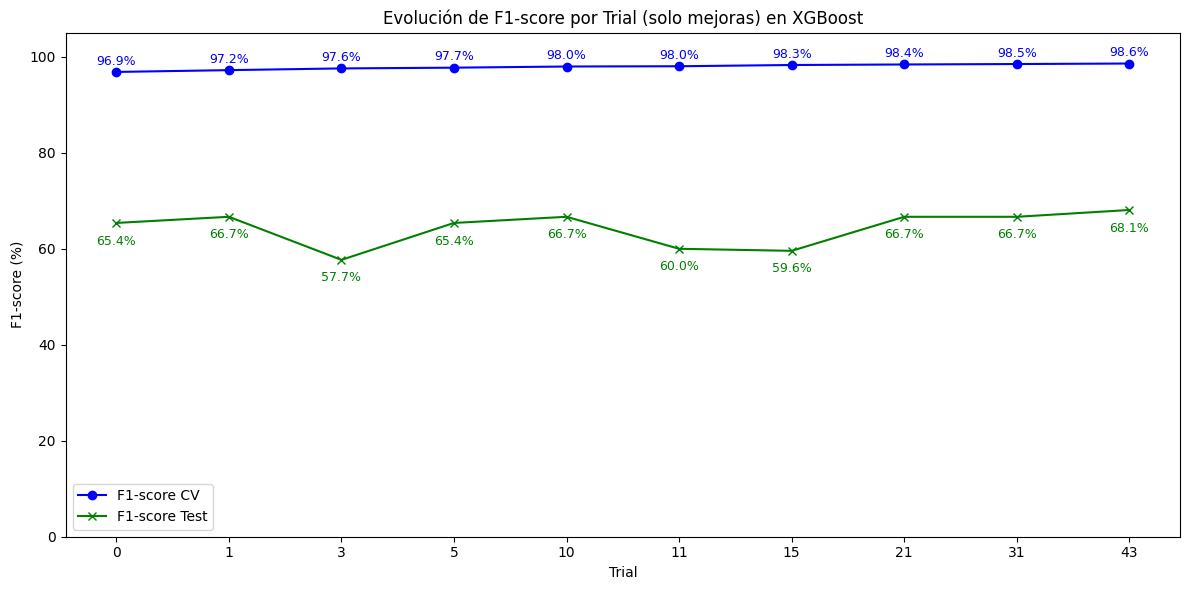

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

df_best_trials = pd.DataFrame(results).reset_index(drop=True)

plt.figure(figsize=(12, 6))

x_vals = df_best_trials.index  # índices equidistantes

# Gráficas
plt.plot(x_vals, df_best_trials["f1_cv"]* 100, marker="o", label="F1-score CV", color="blue")
plt.plot(x_vals, df_best_trials["f1_test"]* 100, marker="x", label="F1-score Test", color="green")

# Anotar valores en porcentaje con 1 decimal
for i, row in df_best_trials.iterrows():
    plt.text(i, row["f1_cv"] * 100 + 1.5, f"{row['f1_cv'] * 100:.1f}%", color="blue", ha="center", fontsize=9)
    plt.text(i, row["f1_test"] * 100 - 4.5, f"{row['f1_test'] * 100:.1f}%", color="green", ha="center", fontsize=9)

# Etiquetas del eje X
plt.xticks(ticks=x_vals, labels=df_best_trials["trial_number"])

# Estética
plt.title("Evolución de F1-score por Trial (solo mejoras) en XGBoost")
plt.xlabel("Trial")
plt.ylabel("F1-score (%)")
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()

# Eliminar grid
plt.grid(False)

plt.show()


In [90]:
xgb_model = xgb.XGBClassifier(**study.best_params)
xgb_model.fit(X_train_bal, y_train_bal)
y_pred_test = xgb_model.predict(X_test)
f1_test = f1_score(y_test, y_pred_test,average='binary')
print("F1-score en Test:", f1_test)
y_pred_xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
_,y_pred_xgb_opt = getBestThreshold(y_pred_xgb_prob,y_test)
f1_test_opt = f1_score(y_test, y_pred_xgb_opt,average='binary')
print("F1-score opt en Test:", f1_test_opt)


F1-score en Test: 0.6808510638297872
F1-score opt en Test: 0.72


In [91]:
print("AUC en Test:", roc_auc_score(y_test,y_pred_xgb_prob))

AUC en Test: 0.9212430821626224
